In [1110]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.feature_selection import RFECV, RFE, SelectKBest, f_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt

In [1111]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
min_max_scaler = MinMaxScaler()
standar_scaler = StandardScaler()
bc = PowerTransformer(method="box-cox")
yj = PowerTransformer(method="yeo-johnson")
rng = np.random.RandomState(304)
qt = QuantileTransformer(n_quantiles=500, output_distribution="normal", random_state=rng)

In [1112]:
def graficar_info_variable(variable, b=8):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    sns.histplot(data=variable, bins=b ,ax=axes[0])
    sns.boxplot(data=variable, ax=axes[1])
    sns.violinplot(data=variable, ax=axes[2])

def porcentaje_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    BI = Q1 - 1.5*IQR
    BS = Q3 + 1.5*IQR
    out = ((data < BI) | (data > BS))
    print("Porcentaje de outliers: ", 100*out.sum()/out.count())

def quitar_outliers(data, df_feature):
    Q1 = df_feature.quantile(0.25)
    Q3 = df_feature.quantile(0.75)
    IQR = Q3 - Q1
    BI = Q1 - 1.5*IQR
    BS = Q3 + 1.5*IQR
    out = ((df_feature > BI) & (df_feature < BS))
    data = data.loc[out]
    return data

#### Leer Dataset

In [1113]:
df = pd.read_csv('ToyotaCorolla_modificado - ToyotaCorolla_modificado.csv')
df.head(11)

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,1,0,0,0,1,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,1,0,1,0,0,0,1,0,0,0
2,3,?TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,0,1,0,0,0,1,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,...,0,0,1,0,0,0,1,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,...,1,1,1,0,1,0,1,0,0,0
5,6,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,12950,32,1,2002,61000,Diesel,90,0,...,1,1,1,0,1,0,1,0,0,0
6,7,?TOYOTA Corolla 2.0 D4D 90 3DR TERRA 2/3-Doors,16900,27,6,2002,94612,Diesel,90,1,...,1,1,1,0,0,1,1,0,0,0
7,8,TOYOTA Corolla 2.0 D4D 90 3DR TERRA 2/3-Doors,18600,30,3,2002,75889,Diesel,90,1,...,1,1,1,0,0,0,1,0,0,0
8,9,?TOYOTA Corolla 1800 T SPORT VVT I 2/3-Doors,21500,27,6,2002,19700,Petrol,192,0,...,1,1,1,1,0,0,0,1,1,0
9,10,?TOYOTA Corolla 1.9 D HATCHB TERRA 2/3-Doors,12950,23,10,2002,71138,Diesel,69,0,...,0,0,1,0,0,0,1,0,0,0


### Análisis de variables

In [1114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1436 non-null   int64 
 1   Model             1436 non-null   object
 2   Price             1436 non-null   int64 
 3   Age_08_04         1436 non-null   int64 
 4   Mfg_Month         1436 non-null   int64 
 5   Mfg_Year          1436 non-null   int64 
 6   KM                1436 non-null   int64 
 7   Fuel_Type         1436 non-null   object
 8   HP                1436 non-null   int64 
 9   Met_Color         1436 non-null   int64 
 10  Automatic         1436 non-null   int64 
 11  cc                1436 non-null   int64 
 12  Doors             1436 non-null   int64 
 13  Cylinders         1436 non-null   int64 
 14  Gears             1436 non-null   int64 
 15  Quarterly_Tax     1436 non-null   int64 
 16  Weight            1436 non-null   int64 
 17  Mfr_Guarantee 

In [1115]:
df.describe()

,Id,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000,...,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000
mean,721.555014,10730.824513,55.947075,5.548747,1999.625348,68533.259749,101.502089,0.674791,0.055710,1576.85585,...,0.580084,0.561978,0.977716,0.146240,0.256964,0.300139,0.770195,0.204735,0.145543,0.277855
std,416.476890,3626.964585,18.599988,3.354085,1.540722,37506.448872,14.981080,0.468616,0.229441,424.38677,...,0.493717,0.496317,0.147657,0.353469,0.437111,0.458478,0.420854,0.403649,0.352770,0.448098
min,1.000000,4350.000000,1.000000,1.000000,1998.000000,1.000000,69.000000,0.000000,0.000000,1300.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,361.750000,8450.000000,44.000000,3.000000,1998.000000,43000.000000,90.000000,0.000000,0.000000,1400.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,721.500000,9900.000000,61.000000,5.000000,1999.000000,63389.500000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1081.250000,11950.000000,70.000000,8.000000,2001.000000,87020.750000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1442.000000,32500.000000,80.000000,12.000000,2004.000000,243000.000000,192.000000,1.000000,1.000000,16000.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### ID, Model, Cylinders (no tener en cuenta)

In [1116]:
#Eliminar signo de interrogación de modelo
df.Model = df.Model.apply(lambda x: x.replace('?', ''))
print("Valores únicos de modelos: ",len(df.Model.value_counts()))

Valores únicos de modelos:  319


In [1117]:
#Encoder Fuel Type
fuel_encoder = one_hot_encoder.fit(df.Fuel_Type.values.reshape(-1, 1))
name_fuel = fuel_encoder.categories_[0]
fuel_encoder = fuel_encoder.transform(df.Fuel_Type.values.reshape(-1, 1))
fuel_type_encoder = pd.DataFrame(fuel_encoder.toarray(), columns=name_fuel)
df = df.drop(columns=['Fuel_Type'])
df = pd.concat([df, fuel_type_encoder], axis=1)

In [1118]:
df = df.drop(columns=['Model', 'Id', 'Cylinders'])

In [1119]:
correlations = df.corr()
correlations.style.background_gradient(cmap='Greens')

,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,Doors,Gears,Quarterly_Tax,Weight,Mfr_Guarantee,BOVAG_Guarantee,Guarantee_Period,ABS,Airbag_1,Airbag_2,Airco,Automatic_airco,Boardcomputer,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar,CNG,Diesel,Petrol
Price,1.000000,-0.876590,-0.018138,0.885159,-0.569960,0.314990,0.108905,0.033081,0.126389,0.185326,0.063104,0.219197,0.581198,0.197802,0.028133,0.146627,0.306138,0.093588,0.248974,0.429259,0.588262,0.601292,0.481374,0.343458,0.356518,0.064275,-0.041887,0.222083,0.164121,0.102569,0.108564,-0.043179,-0.172369,-0.039536,0.054084,-0.038516
Age_08_04,-0.876590,1.000000,-0.123255,-0.983661,0.505672,-0.156622,-0.108150,0.031717,-0.098084,-0.148359,-0.005364,-0.198431,-0.470253,-0.164658,0.006865,-0.152563,-0.412887,-0.105406,-0.329017,-0.403600,-0.426259,-0.719449,-0.510895,-0.279631,-0.283856,-0.069192,0.013791,-0.126895,-0.110988,-0.116751,-0.040045,0.012857,0.188720,0.002389,-0.097740,0.092611
Mfg_Month,-0.018138,-0.123255,1.000000,-0.057416,-0.020630,-0.039312,0.030266,0.009146,0.037387,-0.012069,-0.013063,0.031373,-0.002167,-0.005771,-0.003863,0.029010,0.072532,0.003756,0.076749,0.057088,-0.049017,0.017715,-0.016736,0.010055,0.025185,-0.055495,0.031601,-0.033504,0.052789,0.023245,0.023506,0.032576,-0.042170,0.001289,0.051501,-0.049646
Mfg_Year,0.885159,-0.983661,-0.057416,1.000000,-0.504974,0.164697,0.103310,-0.033567,0.091892,0.151442,0.007766,0.193934,0.473478,0.166697,-0.006206,0.148218,0.402215,0.105359,0.317075,0.395674,0.437718,0.720567,0.517008,0.279490,0.280996,0.079676,-0.019607,0.133737,0.102080,0.113237,0.036022,-0.018844,-0.182206,-0.002637,0.088986,-0.084162
KM,-0.569960,0.505672,-0.020630,-0.504974,1.000000,-0.333538,-0.080503,-0.081854,0.102683,-0.036197,0.015023,0.278165,-0.028598,-0.212851,0.001438,-0.138942,-0.177203,-0.018012,-0.139275,-0.133057,-0.258221,-0.353862,-0.266826,-0.125177,-0.156242,0.007397,0.013661,-0.074327,-0.044784,-0.045658,-0.013599,0.015770,0.084153,0.144016,0.403060,-0.433160
HP,0.314990,-0.156622,-0.039312,0.164697,-0.333538,1.000000,0.058712,0.013144,0.035856,0.092424,0.209477,-0.298432,0.089614,0.140026,0.022701,0.076163,0.057832,0.025137,0.017644,0.241134,0.244957,0.129715,0.102300,0.250122,0.265593,0.048850,0.020998,0.210571,-0.006027,0.010908,0.206784,0.019919,0.068271,0.062109,-0.533453,0.489110
Met_Color,0.108905,-0.108150,0.030266,0.103310,-0.080503,0.058712,1.000000,-0.019335,0.031812,0.085243,0.018601,0.011326,0.057929,0.154850,0.010783,0.009295,0.022298,0.100055,0.038416,0.114190,0.027977,0.089886,0.198220,0.153307,0.145147,0.086544,0.072756,0.023821,0.003779,0.037741,0.053829,0.071530,0.148536,0.021009,-0.012420,0.004872
Automatic,0.033081,0.031717,0.009146,-0.033567,-0.081854,0.013144,-0.019335,1.000000,0.066740,-0.027654,-0.098555,-0.055371,0.057249,0.026194,0.023393,-0.002256,-0.016128,-0.011895,0.001171,-0.028353,0.059057,-0.037069,-0.010967,-0.002502,-0.005864,-0.004469,-0.014600,0.003077,0.013175,-0.018876,-0.078095,-0.014150,0.018786,0.001486,-0.084490,0.080249
cc,0.126389,-0.098084,0.037387,0.091892,0.102683,0.035856,0.031812,0.066740,1.000000,0.079903,0.014629,0.306996,0.335637,-0.057407,-0.081725,-0.017683,0.037806,0.022678,0.024738,0.119888,0.162669,0.009312,0.057787,0.072634,0.055299,0.032933,-0.000361,0.017326,-0.035195,-0.055711,0.003236,-0.000470,0.002725,0.005941,0.327723,-0.315170
Doors,0.185326,-0.148359,-0.012069,0.151442,-0.036197,0.092424,0.085243,-0.027654,0.079903,1.000000,-0.160141,0.109363,0.302618,0.037689,-0.014311,0.053654,0.063733,0.053828,0.021734,0.170544,0.054809,0.089606,0.094653,0.132092,0.107626,0.059792,-0.008318,0.064705,-0.129881,-0.022542,-0.039555,-0.008265,0.102292,0.009680,0.025495,-0.027589


### Variables eliminadas por bajo grado de correlación < 0.25

In [1120]:
df = df.drop(columns=['Mfg_Month', 'Met_Color', 'Automatic', 'cc', 'Doors', 'Gears', 'Quarterly_Tax', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'Guarantee_Period',
                      'Airbag_1', 'Airbag_2', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette',
                      'Tow_Bar', 'CNG', 'Diesel', 'Petrol'])

### Price (variable objetivo)

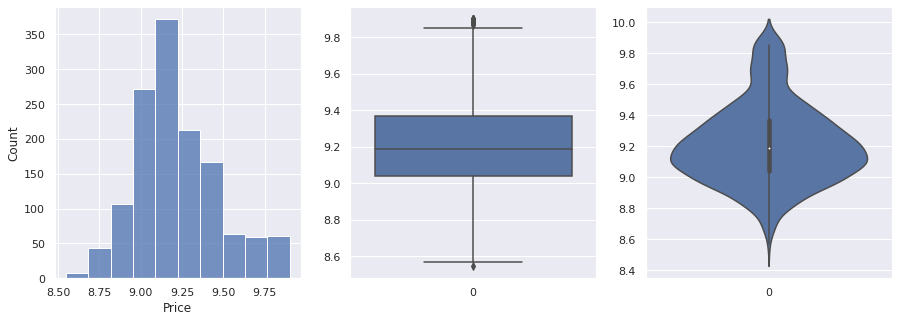

In [1160]:
graficar_info_variable(df.Price, 10)

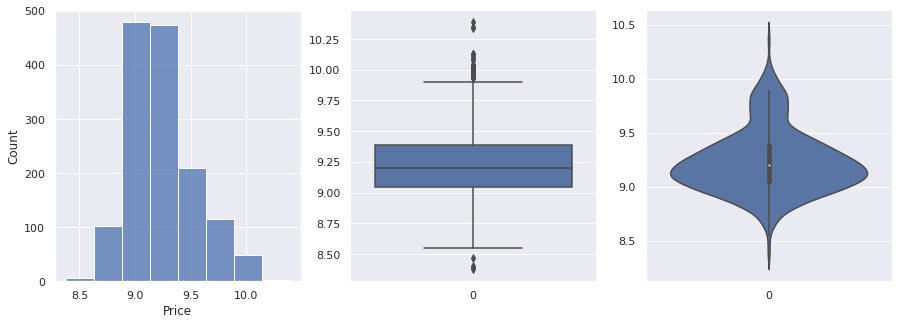

In [1122]:
df.Price = np.log(df.Price)
graficar_info_variable(df.Price)

In [1123]:
porcentaje_outliers(df.Price)
df = quitar_outliers(df, df.Price)
porcentaje_outliers(df.Price)

Porcentaje de outliers:  2.8551532033426184
Porcentaje de outliers:  1.6487455197132617


### AGE_08_04

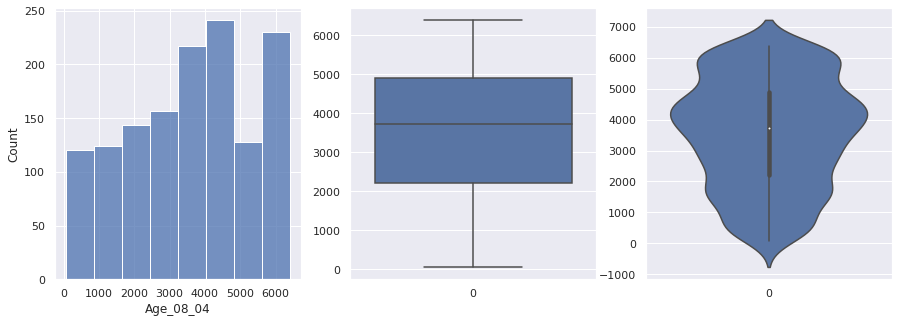

In [1161]:
graficar_info_variable(df.Age_08_04)

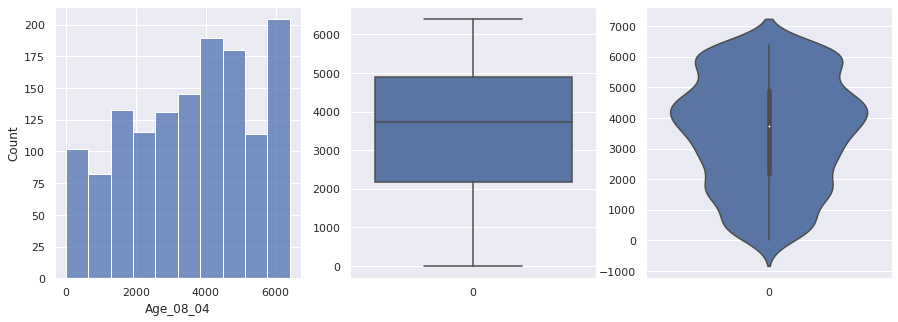

In [1125]:
df.Age_08_04= df.Age_08_04**2
graficar_info_variable(df.Age_08_04, 10)

### Mfg_Year

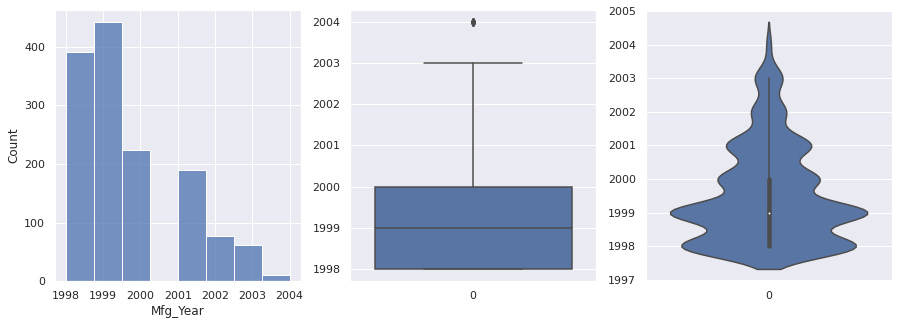

In [1126]:
graficar_info_variable(df.Mfg_Year)

### KM

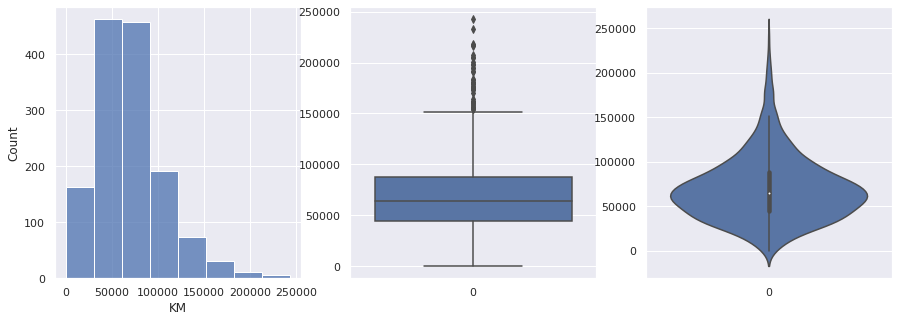

In [1127]:
graficar_info_variable(df.KM)

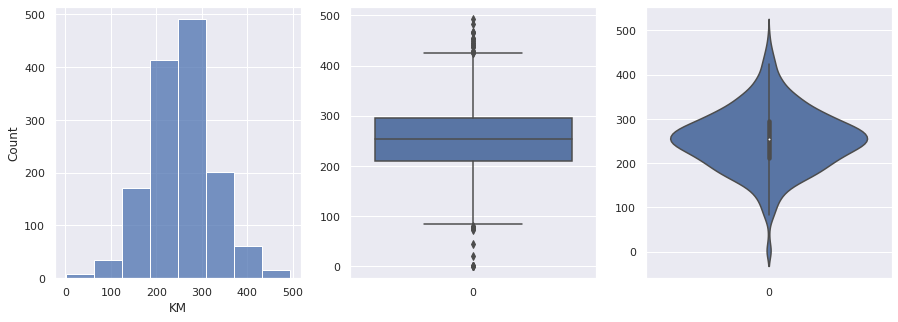

In [1128]:
df.KM = np.sqrt(df.KM)
graficar_info_variable(df.KM)

In [1129]:
porcentaje_outliers(df.KM)
df = quitar_outliers(df, df.KM)
porcentaje_outliers(df.KM)

Porcentaje de outliers:  2.4372759856630823
Porcentaje de outliers:  0.7347538574577517


### HP

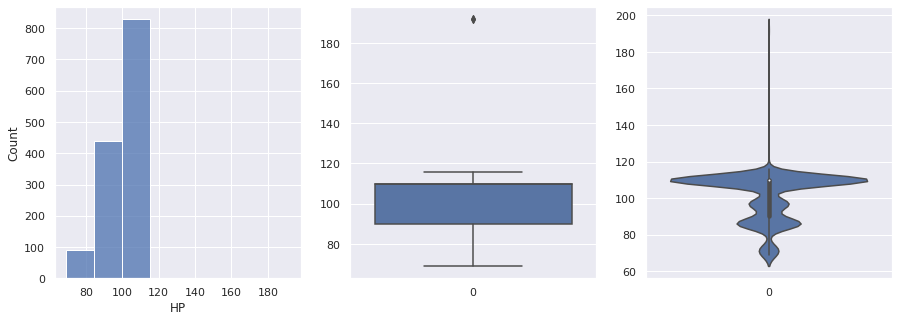

In [1130]:
graficar_info_variable(df.HP)

In [1131]:
#prueba = df.HP
#prueba = qt.fit_transform(prueba.values.reshape(-1, 1))
#graficar_info_variable(prueba)

### Weight

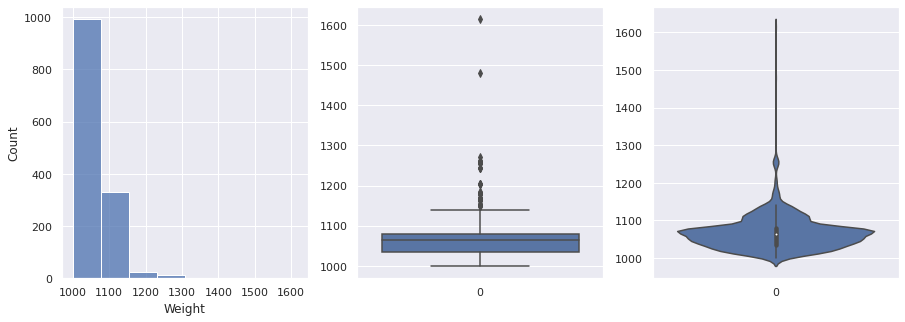

In [1132]:
graficar_info_variable(df.Weight)

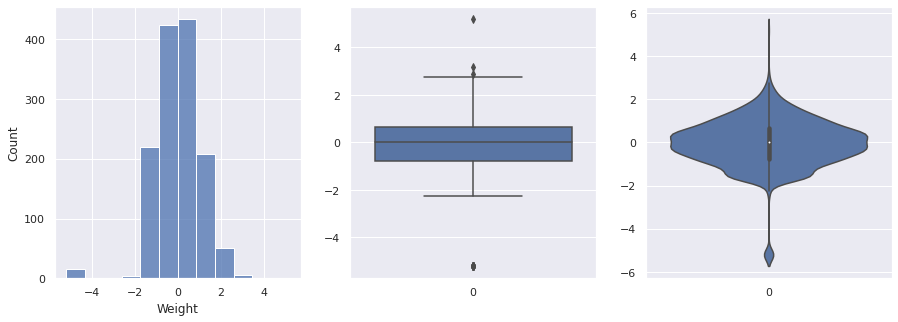

In [1133]:
df.Weight = qt.fit_transform(df.Weight.values.reshape(-1, 1))
graficar_info_variable(df.Weight, 12)

### ABS

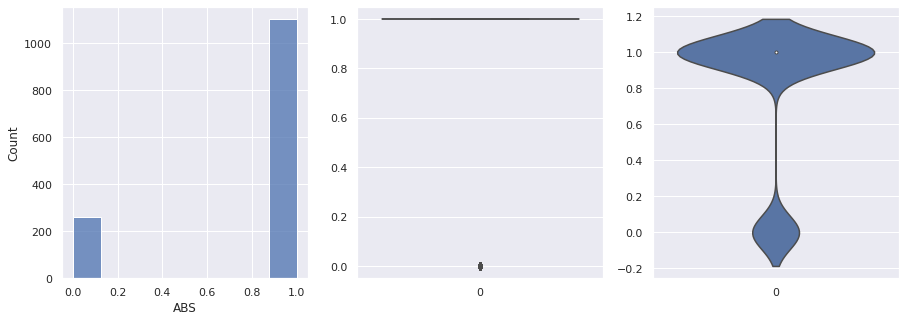

In [1134]:
graficar_info_variable(df.ABS)

### Airco

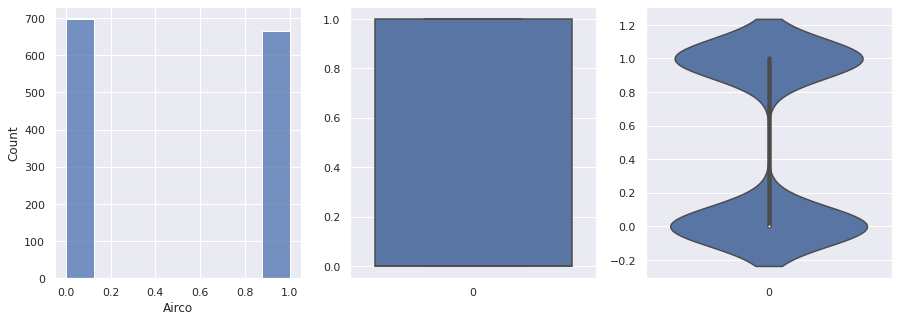

In [1135]:
graficar_info_variable(df.Airco)

### Automatic Airco

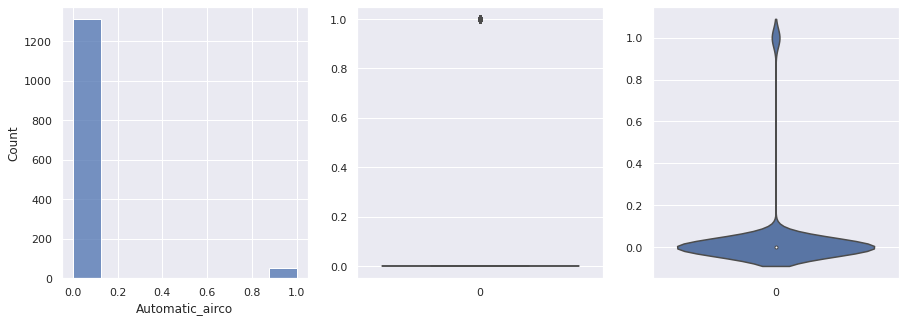

In [1136]:
graficar_info_variable(df.Automatic_airco)

### Boardcomputer

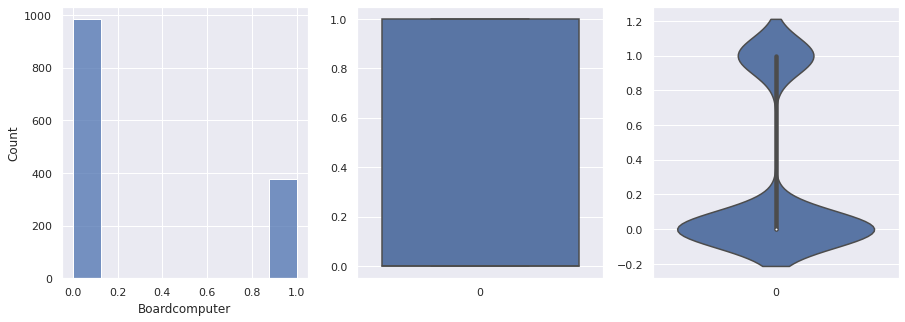

In [1137]:
graficar_info_variable(df.Boardcomputer)

### CD_Player

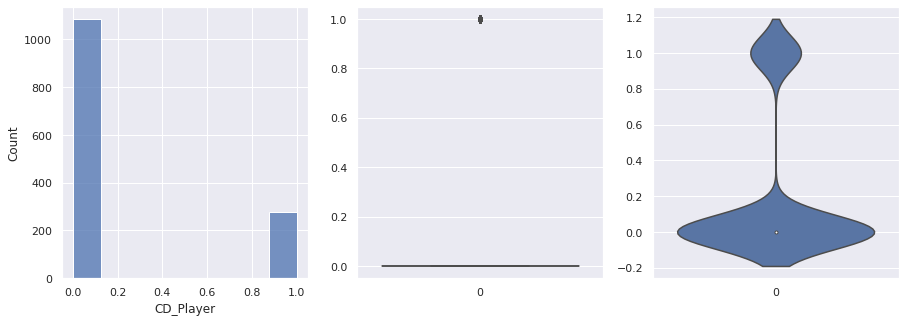

In [1138]:
graficar_info_variable(df.CD_Player)

### Central Lock

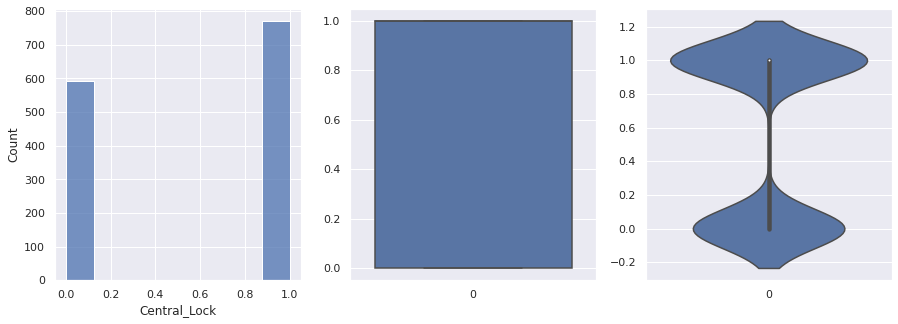

In [1139]:
graficar_info_variable(df.Central_Lock)

### Powered Window

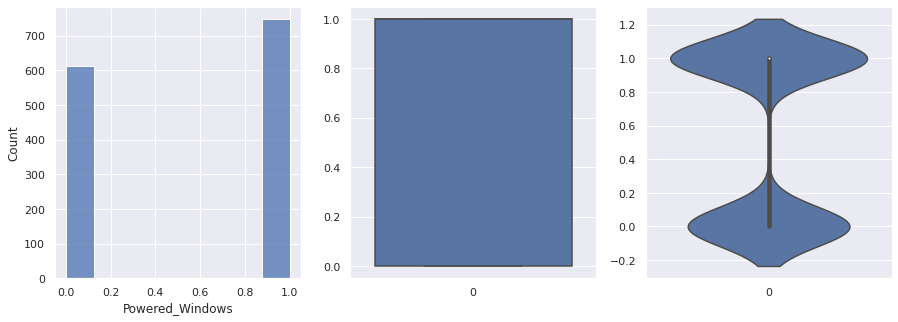

In [1140]:
graficar_info_variable(df.Powered_Windows)

### Eliminar variables con p>|t| superiores a 0.05

In [1141]:
df = df.drop(columns=['Mfg_Year', 'Central_Lock', 'HP', 'Boardcomputer'])

### Definir x e y

In [1142]:
y = df.Price
x = df.drop(columns=['Price'])

### Recursive feature elimination

In [1143]:
lin_reg = LinearRegression()
rfe_mod = RFECV(lin_reg, step=1, cv=5, scoring='r2')
#rfe_mod = RFE(lin_reg, n_features_to_select=4, step=1)
myvalues=rfe_mod.fit(x,y)
names=pd.DataFrame(x.columns)
rankings=pd.DataFrame(myvalues.ranking_)

In [1144]:
ranked=pd.concat([names,rankings], axis=1)
ranked.columns = ["Feature", "Rank"]
ranked

,Feature,Rank
0,Age_08_04,1
1,KM,1
2,Weight,1
3,ABS,1
4,Airco,1
5,Automatic_airco,1
6,CD_Player,1
7,Powered_Windows,1


/home/jeo/anaconda3/envs/data/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


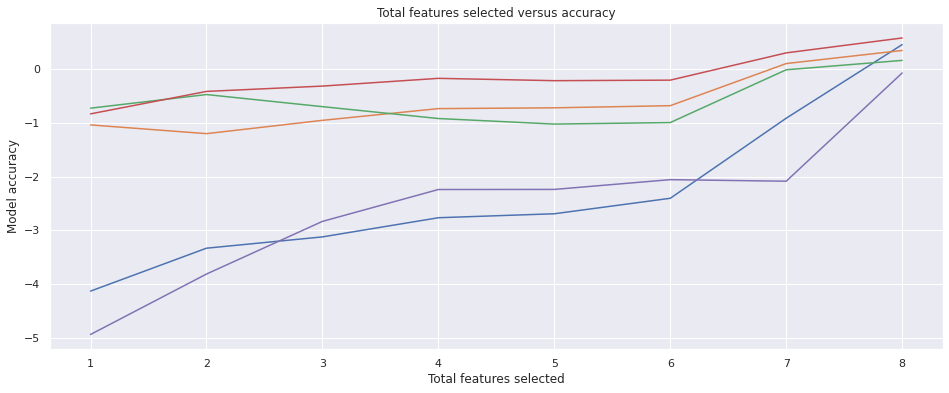

In [1145]:
plt.figure( figsize=(16, 6))
plt.title('Total features selected versus accuracy')
plt.xlabel('Total features selected')
plt.ylabel('Model accuracy')
plt.plot(range(1, len(myvalues.grid_scores_) + 1), myvalues.grid_scores_)
plt.show()


### Univariate Feature Selection

In [1146]:
m = SelectKBest(score_func=f_regression, k=4)
r = m.fit(x, y)

In [1147]:
results_df=pd.DataFrame(r.scores_)
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Score"]
scored.sort_values(by=['Score'])

,Feature,Score
7,Powered_Windows,165.258840
3,ABS,181.466349
5,Automatic_airco,262.865683
2,Weight,322.045240
4,Airco,326.624821
6,CD_Player,341.779551
1,KM,749.278463
0,Age_08_04,3454.396034


### LASSO

In [1148]:
lasso = LassoCV(cv=5, random_state=0, max_iter=1000)
lasso.fit(x, y)

LassoCV(cv=5, random_state=0)

In [1149]:
results_df=pd.DataFrame(lasso.coef_)
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Coef"]
scored.sort_values(by=['Coef'])

,Feature,Coef
1,KM,-0.000803
0,Age_08_04,-0.000109
2,Weight,0.000000
3,ABS,-0.000000
4,Airco,0.000000
5,Automatic_airco,0.000000
6,CD_Player,0.000000
7,Powered_Windows,0.000000


### foward

In [1150]:
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out = 0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

stepwise_selection(x, y)

/tmp/ipykernel_8479/845411012.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/tmp/ipykernel_8479/845411012.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/tmp/ipykernel_8479/845411012.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/tmp/ipykernel_8479/845411012.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/tmp/ipykernel_8479/845411012.py:24: FutureWarning: 

Add  Age_08_04                      with p-value 0.0
Add  KM                             with p-value 4.09193e-46
Add  Weight                         with p-value 8.20181e-51
Add  Powered_Windows                with p-value 1.44576e-22
Add  Automatic_airco                with p-value 3.1195e-18
Add  Airco                          with p-value 9.94758e-06
Add  CD_Player                      with p-value 0.000197875


/tmp/ipykernel_8479/845411012.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


['Age_08_04',
 'KM',
 'Weight',
 'Powered_Windows',
 'Automatic_airco',
 'Airco',
 'CD_Player']

### Entrenar Modelo

In [1151]:
x = x[['Age_08_04', 'KM', 'Weight']]
#x = x.drop(columns=['Powered_Windows'])

In [1152]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, y_train.shape

((1088, 3), (1088,))

In [1153]:
ml = sm.OLS(y_train, sm.add_constant(x_train))
ml_results = ml.fit()
ml_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     1399.
Date:                Mon, 10 Oct 2022   Prob (F-statistic):               0.00
Time:                        22:53:18   Log-Likelihood:                 787.52
No. Observations:                1088   AIC:                            -1567.
Df Residuals:                    1084   BIC:                            -1547.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8323      0.015    674.262      0.000       9.804       9.861
Age_08_04  -9.213e-05   2.52e-06    -36.618      0.000   -9.71e-05   -8.72e-05
KM            -0.0011   6.52e-05    -17.274      0.000      -0.001      -0.001
Weight         0.0524      0.004     14.754      0.000       0.045       0.059
==============================================================================
Omnibus:                       66.168   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.742
Skew:                          -0.392   Prob(JB):                     3.34e-30
Kurtosis:                       4.542   Cond. No.                     1.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1154]:
x_train.corr().style.background_gradient(cmap='Greens')

,Age_08_04,KM,Weight
Age_08_04,1.000000,0.490729,-0.349308
KM,0.490729,1.000000,-0.004515
Weight,-0.349308,-0.004515,1.000000


In [1155]:
y_pred = ml_results.predict(sm.add_constant(x_test))
print("Mean squared error: %.2f" % mean_squared_error(y_test,y_pred))

Mean squared error: 0.01


In [1156]:
# Valores Ajustados
fitted_values = ml_results.fittedvalues

# Valores residuales
residuals = ml_results.resid

#residuales estandarizados
lm_resid_stand = ml_results.get_influence().resid_studentized_internal

#raiz de los residuales normalizados absolutos
lm_resid_norm_abs_sqrt = np.sqrt(np.abs(lm_resid_stand))

#residuales absolutos
lm_resid_abs = np.abs(residuals)

In [1157]:
sns.set(rc = {'figure.figsize':(15,8)})

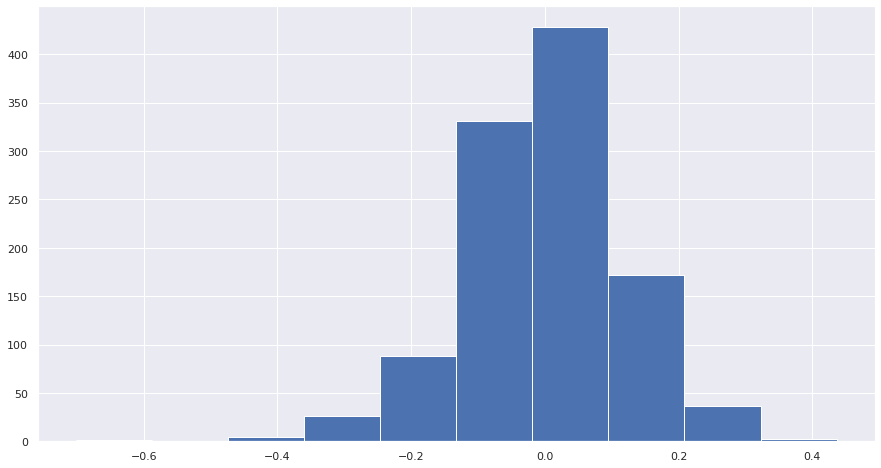

In [1158]:
# Residuales
plt.hist(ml_results.resid)
plt.show()

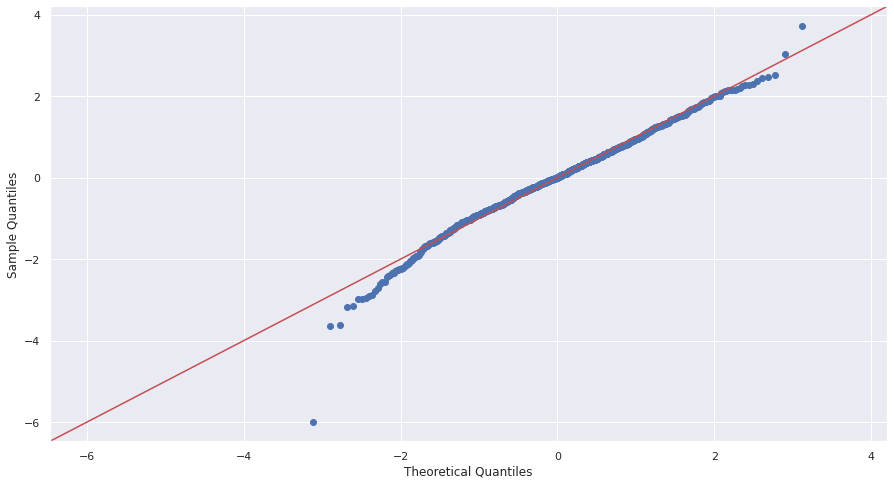

In [1159]:
def grafico_qqplot():
    fig = sm.qqplot(lm_resid_stand,line='45')
    plt.show()

grafico_qqplot()

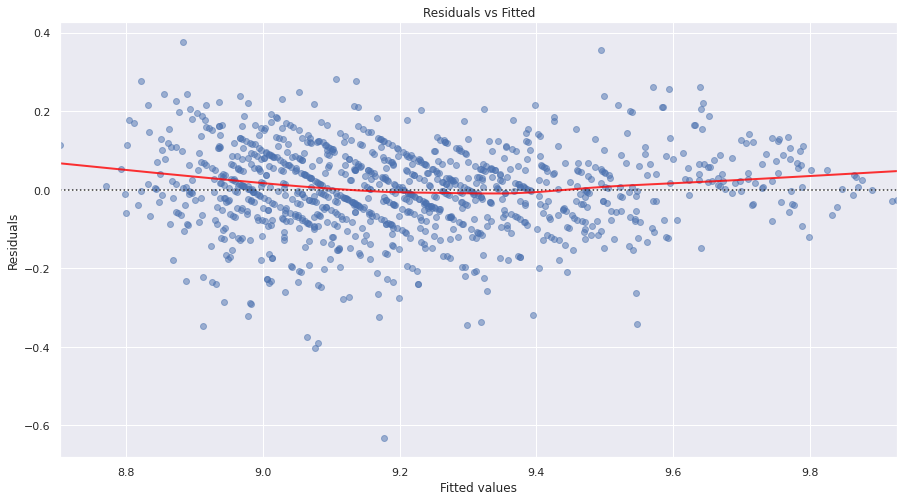

In [1043]:
def residuales_vs_ajustados():
    plot = sns.residplot(x=fitted_values, y=residuals, lowess=True,
                         scatter_kws={'alpha': 0.5},
                         line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})

    # Titel and labels
    plot.set_title('Residuals vs Fitted')
    plot.set_xlabel('Fitted values')
    plot.set_ylabel('Residuals')
residuales_vs_ajustados()